<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Eletronics Purchase Prediction

Today you are a machine learning engineer in the Department of Marketing and Inventory at Walmart Labs. You have access to the Walmart server data, specifically the Electronics section. However, there is no customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether or not some product will be purchased.

Data is adapted from [e-commerce behavior data on Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). 

This file contains behavior data from a large multi-category store. Each row in the file represents an event. All events are related to products and users. Each event has a many-to-many relationship between users and products. 

## Learning Objectives

At the end of this session, you will be able to

- Leverage `pandas_profiling` for fast data understanding
- Practice data preprocessing
- Build logistic regression / SVM / Gradient Boosting
- Evaluate models with proper metrics
- Interpret black box models with SHAP
- Generate optimal pipeline for classification task using AutoML

## Task 1: Load data

Let's start by looking at the descriptions before loading in the csv files.

1. Use the `IPython.display` module to view the `some_column_descriptions.png` file. Look through the column names and descriptions to get an idea of what the data is.

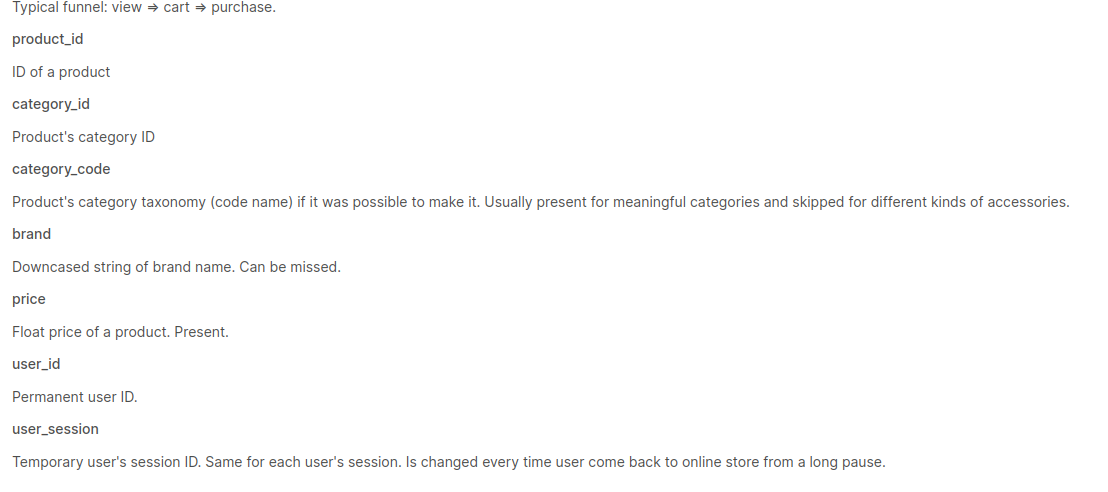

In [13]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/some_column_descriptions.png'
display(Image(filename=filename))

The dataset has User-journey data, i.e., it tracks information on user/product pairs over time to see if the combination results in a purchase.

2. Look at the `user_journey_descriptions.png` file. Review the data sample to get a sense of what information we are tracking for each user/product pair.

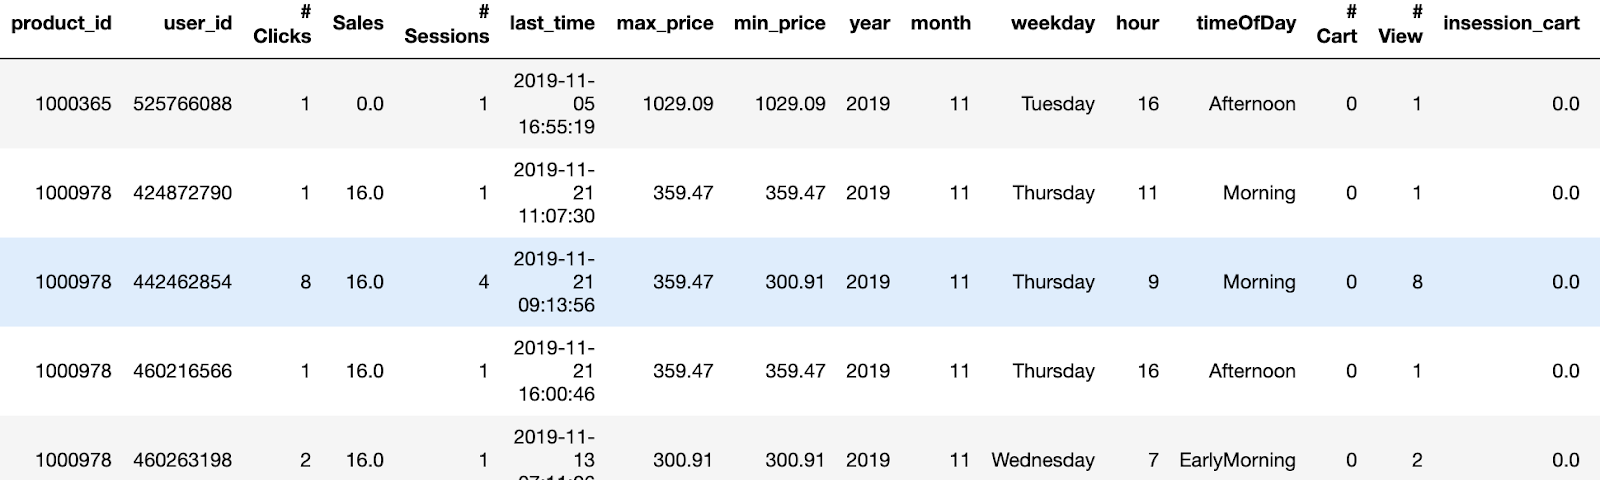

In [14]:
# change path to wherever you uploaded/downloaded the file
filename='../img/user_journey_descriptions.png'
display(Image(filename=filename))

The dataset we are working with is essentially what we have screenshotted above, but has been anonymized by removing product IDs and user IDs.

3. Use the pandas `read_csv()` and `head()` functions to read in the training data (`../dat/train.csv.gz`) and look at the first few rows.

    Note the `Purchase` column has values either 0 (not purchased) or 1 (purchased).

In [15]:
import pandas as pd
train_df = pd.read_csv("../dat/train.csv.gz") # YOUR CODE HERE

In [16]:
# YOUR CODE HERE
train_df.tail(5)

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
645811,1,1,0.0,128.67,128.67,0,1,0,2,2019,11,Sat,EarlyMorning,0,0
645812,1,1,0.0,244.51,244.51,0,1,0,1,2019,11,Thu,EarlyMorning,0,0
645813,1,1,0.0,152.82,152.82,0,1,0,1,2019,11,Sun,EarlyMorning,0,0
645814,1,1,0.0,190.22,190.22,0,1,0,1,2019,11,Wed,Evening,0,0
645815,1,1,0.0,24.41,24.41,0,1,0,1,2019,11,Wed,Afternoon,0,0


In [17]:
train_df['timeOfDay'].unique()

array(['Morning', 'Dawn', 'Afternoon', 'Noon', 'Evening', 'EarlyMorning',
       'Night'], dtype=object)

4. What is the dimension of the training data?

In [18]:
# YOUR CODE HERE
train_df.shape

(645816, 15)

5. Similarly, read in the test data `../dat/test.csv.gz` and check its dimension.

In [19]:
test_df = pd.read_csv("../dat/test.csv.gz") # YOUR CODE HERE
test_df.shape

(430544, 15)

## Task 2: Understand data

Our goal here is to predict whether a customer/product pair will result in a purchase. 
To do this, we will want to identify the most important features for classification. 

Before digging into each column, let's leverage `pandas_profiling`, that goes beyond `pd.DataFrame.describe()`, to get a big picture of our data set. 

1. From `pandas_profiling` import `ProfileReport`. 
    
    For faster iteration, create a profile report object `profile` with 10,000 samples from `train_df`. 
    
    Set its `title` as "Pandas Profiling Electronics Purchase Report". 
    
    For sampling, use `pd.DataFrame.sample(10000, randome_state=3)`. 

In [20]:
!pip install pandas==1.3
!pip show pandas
!pip install pandas_profiling
!pip install matplotlib

Name: pandas
Version: 1.3.0
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /Users/ranganaigwati/opt/anaconda3/lib/python3.9/site-packages
Requires: numpy, python-dateutil, pytz
Required-by: xarray, visions, TPOT, sweetviz, statsmodels, shap, seaborn, scattertext, phik, pandas-profiling, hvplot, holoviews, datashader, cufflinks


In [21]:
#!pip install --upgrade pandas
# YOUR CODE HERE
#import pandas_profiling
import matplotlib
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
#sample_data=train_df.sample(10000, random_state=3)
#profile = ProfileReport(sample_data,"Pandas Profiling Electronics Purchase Report") # YOUR CODE HERE

In [22]:
#sample_data=train_df.sample(10000, random_state=3)
#profile = ProfileReport(sample_data, title = "Pandas Profiling Electronics Purchase Report") # YOUR CODE HERE
profile = ProfileReport(train_df.sample(10000, random_state=3), title="Pandas Profiling Electronics Purchase Report")

   Show the report inside the notebook, go over the report and check each tab; especially the "Alerts". 

In [23]:
%%time
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 28.6 s, sys: 2.05 s, total: 30.7 s
Wall time: 25.9 s


2. Pandas profiling Profile reports that there are 5 numeric variables and 11 categorical variables. Let's print out the datatype of each feature (column) and understand how the profiler infers data type. 

In [24]:
#YOUR CODE HERE
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645816 entries, 0 to 645815
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NumOfEventsInJourney  645816 non-null  int64  
 1   NumSessions           645816 non-null  int64  
 2   interactionTime       645816 non-null  float64
 3   maxPrice              645816 non-null  float64
 4   minPrice              645816 non-null  float64
 5   NumCart               645816 non-null  int64  
 6   NumView               645816 non-null  int64  
 7   InsessionCart         645816 non-null  int64  
 8   InsessionView         645816 non-null  int64  
 9   year                  645816 non-null  int64  
 10  month                 645816 non-null  int64  
 11  weekday               645816 non-null  object 
 12  timeOfDay             645816 non-null  object 
 13  Weekend               645816 non-null  int64  
 14  Purchase              645816 non-null  int64  
dtype

3. From the report, we see that `year`, `month`, and `Weekend` were "Rejected" as there is only one distinct value for each column. 
These features are not informative, so we remove the three features from the training set. To do this, pass the `columns` argument to the `.drop()` method. 
Make sure to use `inplace=True` to modify the DataFrame. 
Print the shape of the DataFrames to verify the columns were dropped.

In [25]:
assert train_df.shape[1] == 15
# YOUR CODE HERE
train_df.drop(columns=["year","month","Weekend"],inplace=True)
assert train_df.shape[1] == 12

4. Repeat the steps for `test_df`:

In [26]:
# YOUR CODE HERE
test_df.drop(columns=["year","month","Weekend"],inplace=True)
assert test_df.shape[1] == train_df.shape[1]

5. As you can see from the profile report, `weekday` and `timeOfDay` each has 7 distinct values. 
Convert these non-numeric features to numeric. 

    These feature values are ordered temporally, so it makes sense to convert them to numeric type. 
    Follow the example given for the `weekday` column to update the `timeOfDay` column.
    Use the `.head()` method to inspect the dataset after the transformations.

In [27]:
weekday_str2num = {
    s: i+1 for i, s in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fr', 'Sat', 'Sun'])
}
train_df['weekday'] = train_df['weekday'].replace(weekday_str2num)
train_df['weekday'].unique()

array([6, 5, 4, 1, 2, 3, 7])

In [28]:
timeOfDay_str2num = {
    s: i+1 for i, s in enumerate(['Morning', 'Dawn', 'Afternoon', 'Noon', 'Evening', 'EarlyMorning',
       'Night'])
}  # YOUR CODE HERE
train_df['timeOfDay'] = train_df['timeOfDay'].replace(timeOfDay_str2num) # YOUR CODE HERE
train_df['timeOfDay'].unique()

array([1, 2, 3, 4, 5, 6, 7])

6. Do the same for `test_df`, that is, to convert `weekday` and `timeOfDay` into numeric type. 

In [29]:
test_df['weekday'] = test_df['weekday'].replace(weekday_str2num)  # YOUR CODE HERE
test_df['timeOfDay'] = test_df['timeOfDay'].replace(timeOfDay_str2num) # YOUR CODE HERE

7. Use the `Purchase` column in training set to determine the proportion of user journeys that result in purchases.  Compare it to what the profile reports. Is the dataset balanced?

In [30]:
print("number of purchases vs non-purchases in train set:")
print(train_df.Purchase.value_counts())
print(f"percent of rows resulting in purchase:") 
print(100*train_df.Purchase.sum()/train_df.shape[0]) # YOUR CODE HERE

number of purchases vs non-purchases in train set:
0    636839
1      8977
Name: Purchase, dtype: int64
percent of rows resulting in purchase:
1.3900244032355966


## Task 3: Preprocess Data

Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:

- For linear models (e.g., linear regression or logistic regression), [multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) can yield [solutions that are wildly varying and possibly numerically unstable](https://en.wikipedia.org/wiki/Multicollinearity#Consequences).
- Random forest can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
More generally, this can be viewed as a special case of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor). A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of [minimum description length](https://en.wikipedia.org/wiki/Minimum_description_length) makes this more precise ([ref](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)).

1. How many features does our dataset currently have?

In [31]:
# YOUR CODE HERE
print(train_df.shape[1]-1)

11


2. Drop the features with high correlation.

    In the "Correlations" tab in the profile report, you can find heatmap using five different correlation metrics; toggle correlation desciptions if any one of them looks foreign to you.  

    We'll remove high correlated features by looking at each pair of features, and if they are highly correlated (at least 0.8), we won't include the second feature in the pair. Store the remaining set of features (the ones you didn't drop) in dataframes `train_df_reduced`. You are given most the code, make sure that you understand what each line does.
    
    First, calculate the correlation with just 10,000 samples.

In [32]:
train_small_df = train_df.copy().sample(n=int(1e4), random_state=12) 
cor = train_small_df.corr() # YOUR CODE HERE

In [33]:
import numpy as np

keep_columns = np.full(cor.shape[0], True)
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8):
            keep_columns[j] = False
selected_columns = train_df.columns[keep_columns]
train_df_reduced = train_df[selected_columns]

In [34]:
print(selected_columns) 

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')


3. How many columns are left in the DataFrame?

In [35]:
# YOUR CODE HERE
train_df_reduced.shape[1]

9

In [36]:
train_df_reduced.columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

4. Remove the same features from the test set and save in a new dataframe `test_df_reduced`.

In [37]:
test_df_reduced = test_df[['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase']]# YOUR CODE HERE
assert test_df_reduced.shape[1] == 9

In [38]:
test_df_reduced.head()

,NumOfEventsInJourney,interactionTime,maxPrice,NumCart,NumView,InsessionView,weekday,timeOfDay,Purchase
0,1,0.0,126.86,0,1,1,3,6,0
1,2,182.0,118.38,0,2,1,5,6,0
2,1,0.0,63.77,0,1,1,5,1,0
3,1,0.0,32.18,0,1,3,5,6,0
4,1,0.0,1093.72,0,1,2,6,6,0


5. Visualize the selected features and discuss your observations with your team.

    Again, for faster rendering, use the subset `train_small_df_reduced`. If time permits, experiment with some other visualizations of the data.

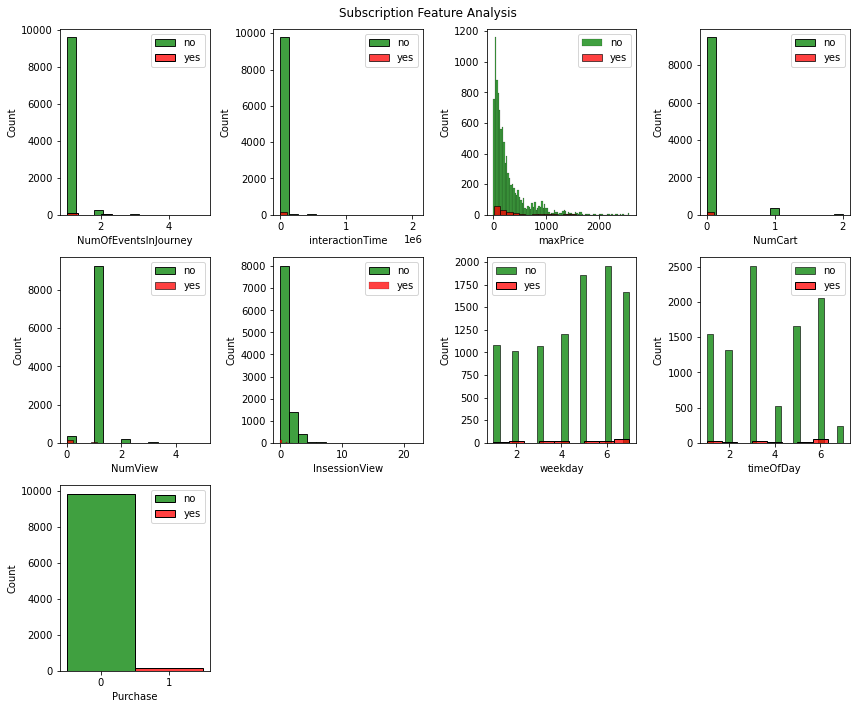

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
train_small_df_reduced = train_small_df[selected_columns]
fig = plt.figure(figsize=(12, 10))
j = 0
for i in train_df_reduced.columns:
    plt.subplot(3, 4, j + 1)
    j += 1
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 0], color='g', label='no')
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 1], color='r', label='yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95);

6. Make the NumPy arrays `X_train_reduced`, `X_test_reduced`, `y_train` and `y_test` from `train_df_reduced` and `test_df_reduced`. 

In [40]:
y_train = train_df_reduced['Purchase'].values
y_test = test_df_reduced['Purchase'].values # YOUR CODE HERE
X_train_reduced = train_df_reduced.drop(columns='Purchase').values
X_test_reduced = test_df_reduced.drop(columns='Purchase').values # YOUR CODE HERE

In [41]:
len(y_test )

430544

In [42]:
X_test_reduced.shape[0]

430544

7. Scale the features in `X_train_reduced` and `X_test_reduced` use `MinMaxScaler`

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # YOUR CODE HERE
X_train_reduced = scaler.fit_transform(X_train_reduced) # YOUR CODE HERE
X_test_reduced = scaler.transform(X_test_reduced) # YOUR CODE HERE

## Task 4: Build Logistic Regression and SVM models

We will be fitting both a Logistic Regression and SVM model to the reduced features and then looking at classification metrics such as Accuracy, Precision, Recall, and F1-score.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

1. Instantiate, train, and predict using the Logistic Regression model.

    Make sure to account for the imbalanced classes with with `class_weight` parameter (what happens if we don't?).

    Remember to use the ***train*** data for training the model and the ***test*** data when making predictions.

In [45]:
%%time

lr_model = LogisticRegression(class_weight='balanced',random_state=42).fit(X=X_train_reduced ,y=y_train) # YOUR CODE HERE

lr_pred = lr_model.predict(X_test_reduced ) # YOUR CODE HERE

CPU times: user 6.32 s, sys: 563 ms, total: 6.88 s
Wall time: 5.1 s


2. Calculate these classification metrics for the Logistic Regression model:

    * accuracy
    * precision
    * recall
    * f1 score
    * confusion matrix

In [46]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9999651603552715
precision: 0.9975550122249389
recall: 1.0
f1 score: 0.9987760097919216
confusion matrix:
[[424409     15]
 [     0   6120]]


3. Instantiate, train and predict using the SVM model. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for usage. 

    Again, remember to account for the class imbalance.

In [47]:
%%time
svm_model = LinearSVC(penalty='l2',class_weight ='balanced',random_state=42).fit(X_train_reduced, y_train) # YOUR CODE HERE 
#svm_model.fit(X_train_reduced, y_train)
svm_pred = svm_model.predict(X_test_reduced)

CPU times: user 2min 20s, sys: 1.27 s, total: 2min 21s
Wall time: 2min 26s


/Users/ranganaigwati/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


4. ❓ What is the time complexity of SVM? What is it for Logistic Regression? Not familiar with the term "time complexity"? Take a read on [Computational Complexity of ML Models
](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770).

    YOUR ANSWER HERE

5. Calculate the classification metrics for the SVM model. 

Here you can use a helper function to display all the metrics. 

Inspect the source code to understand how to use the function. 

In [48]:
from utils import display_metrics
# YOUR CODE HERE
def display_metrics(y_true, y_pred):
    print(f"Confusion Matrix: \n{confusion_matrix(y_true, y_pred)}")
    print(f"Accuracy: {accuracy(y_true, y_pred):.3f}")
    print(f"Recall: {recall(y_true, y_pred):.3f}")
    print(f"Precision: {precision(y_true, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.3f}")
    
    
display_metrics(y_test,svm_pred)
print("accuracy:", accuracy(y_test, svm_pred))
print("precision:", precision(y_test, svm_pred))
print("recall:", recall(y_test, svm_pred))
print("f1 score:", f1_score(y_test, svm_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, svm_pred))

Confusion Matrix: 
[[424424      0]
 [     0   6120]]
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000
accuracy: 1.0
precision: 1.0
recall: 1.0
f1 score: 1.0
confusion matrix:
[[424424      0]
 [     0   6120]]


Wow, that's impressive! Why do you think SVM performs so well? If you are not familiar with Support Vector Machine, check [In-Depth: Support Vector Machines](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) out for better understanding. 

## Task 5: Explanability with SHAP

Intepretation of a linear model such as logistic regression is staightforward, however, some tree-based models have a different reputation. In this task, we will fit a non-linear classifier: begin with gradient boosted tree, and use SHAP to help intepret the model. 

1. What are training coefficients from logistic regression? ( how about SVM? check [How does one interpret SVM feature weights?](https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights) )

    Leave your comments on interpretation of this logistic regression model.

In [49]:
# YOUR CODE HERE


2. Instantiate, train, and predict using the Gradient Boosted Trees model.

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

In [51]:
%%time
gbt_model = GradientBoostingClassifier() # YOUR CODE HERE
gbt_model.fit(X_train_reduced, y_train)
gbt_pred = gbt_model.predict(X_test_reduced)

CPU times: user 58.4 s, sys: 2.21 s, total: 1min
Wall time: 1min 2s


3. Evaluate the model by calculating the classification metrics.

In [52]:
# YOUR CODE HERE
def display_metrics(y_true, y_pred):
    print(f"Confusion Matrix: \n{confusion_matrix(y_true, y_pred)}")
    print(f"Accuracy: {accuracy(y_true, y_pred):.3f}")
    print(f"Recall: {recall(y_true, y_pred):.3f}")
    print(f"Precision: {precision(y_true, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.3f}")
    
    
display_metrics(y_test,gbt_pred)
print("accuracy:", accuracy(y_test, gbt_pred))
print("precision:", precision(y_test, gbt_pred))
print("recall:", recall(y_test, gbt_pred))
print("f1 score:", f1_score(y_test, gbt_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, gbt_pred))

Confusion Matrix: 
[[424423      1]
 [    16   6104]]
Accuracy: 1.000
Recall: 0.997
Precision: 1.000
F1 Score: 0.999
accuracy: 0.9999605150693077
precision: 0.9998361998361999
recall: 0.9973856209150327
f1 score: 0.9986094069529653
confusion matrix:
[[424423      1]
 [    16   6104]]


4. SHAP (SHapley Additive exPlanations) is a game theory approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. You can use package [SHAP](https://github.com/slundberg/shap). 

    For this task, if you are not familar with the concept, read the book chapter [Interpretable Machine Learning - A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/shap.html) first. 

5. Consider experimenting on a smaller dataset. 

For example, start with a subset of 100 samples from the test data.

Once the script works properly, use all the data from `X_test_reduced`. 

Apply `shap.Explainer()` to calculate the SHAP values for the Gradient Boosting classifier you fit earlier.

In [53]:
!pip install shap

In [54]:
np.random.seed(123)
subset_size = X_test_reduced.shape[0] # start with 100
idx = np.random.randint(X_test_reduced.shape[0], size=subset_size)
X_test_reduced_subset = X_test_reduced[idx, ]

assert X_test_reduced_subset.shape == (subset_size, 8)

In [55]:
subset_size

430544

In [56]:
!pip install numpy==1.20


In [57]:
import shap
import numpy as np
explainer = shap.Explainer(gbt_model,X_test_reduced_subset)    # YOUR CODE HERE

In [58]:
np.version.version

'1.20.0'

In [59]:
%%time
shap_values = explainer(X_test_reduced_subset) # YOUR CODE HERE

100%|===================| 429472/430544 [04:32<00:00]        

CPU times: user 4min 20s, sys: 3.05 s, total: 4min 23s
Wall time: 4min 33s


6. visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

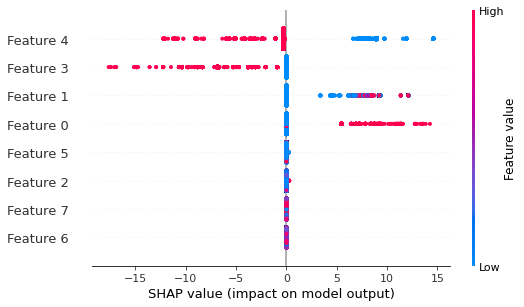

In [60]:
# YOUR CODE HERE
shap.plots.beeswarm(shap_values)

7. What are features 4, 3, and 1? Does each feature positively or negatively contribute to the likelihood of purchase?

In [61]:
# YOUR CODE HERE

8. Visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

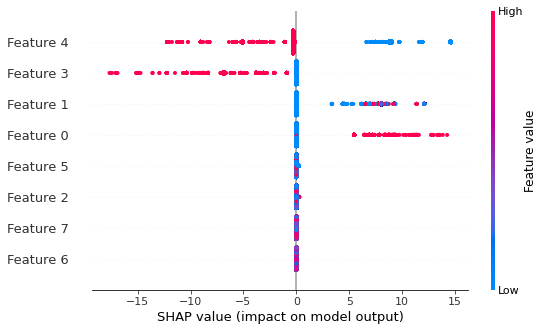

In [62]:
# YOUR CODE HERE
shap.summary_plot(shap_values)

9. Write your data (shap values) to a file and add them under the Model Explainability tab in the Streamlit app (see next section), following the example in Model Results tab.

In [64]:
pd.DataFrame(shap_values).to_csv('shap_values.csv',index=False)

ValueError: DataFrame constructor not properly called!

10. Optional. Do the same for a random forest model.

## Task 6: AutoML

Let's see how AutoML performs on this imbalanced dataset. Similarly, for faster iteration on our workflow, experiment it on a small smaple. 

1. Take 5,000 samples from `train_df`, 5,000 from `test_df` for experimenting.

In [ ]:
!pip install tpot

In [ ]:
train_features = train_df.sample(int(5e3), random_state=42)
train_label = train_features.pop('Purchase')
test_features = test_df.sample(int(5e3), random_state=42)
test_label = test_features.pop('Purchase')

2. Instantiate and train a TPOT auto-ML classifier.

    The parameters in the code below are set to low values for faster iterations. 
    Read about each parameters [here](http://epistasislab.github.io/tpot/api/#classification) and experiment with different values when time permits.
    
    Set a proper [`scoring` function](http://epistasislab.github.io/tpot/using/#scoring-functions). 

In [ ]:
%%time
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=10, 
                      population_size=16,
                      scoring='balanced_accuracy',# YOUR CODE HERE
                      verbosity=2,
                      random_state=42)
tpot.fit(train_features, train_label)
print(f"Tpop score on test data: {tpot.score(test_features, test_label):.2f}")
tpot.export('tpot_electronics_pipeline.py')

3. Examine the model pipeline that TPOT classifier offers in the python file `tpot_electronics_pipeline.py` in the `nb` directory. 
If you see any model, function, or class that are not familiar, look them up!

    Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate.

In [ ]:
!cat tpot_electronics_pipeline.py # A sample output

4. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_electronics_pipeline.py` to build a model on our training set and make predictions on the test set. 

    Choose approriate metrics to evaluate the prediction from TPOT. 
    
    Optional. Add this to Streamlit `models` in the next section.

## Advanced Visualizations with Streamlit and Plotly!
Let's visualize our results in a way that makes it easy to compare our models!  
[Streamlit](https://streamlit.io/) is a Python package that makes it easy to create bespoke, dynamic and interactive web apps for visualizations.  
Lightweight web apps like this are a great way to present results to stakeholders! 

First we need to build our results dataset to render in Streamlit.

In [ ]:
from collections import defaultdict

results_data = defaultdict(list)

models = ["Logistic Regression", "SVM", "Gradient Boosting Classifier"]

for model, pred in zip(models, [lr_pred, svm_pred, gbt_pred]):
    confusion = confusion_matrix(y_test, pred)
    accuracy_ = accuracy(y_test, pred)
    recall_ = recall(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    results_data['model'].append(model)
    results_data['tn'].append(confusion[0][0])
    results_data['fp'].append(confusion[0][1])
    results_data['fn'].append(confusion[1][0])
    results_data['tp'].append(confusion[1][1])
    results_data['accuracy'].append(accuracy_)
    results_data['recall'].append(recall_)
    results_data['f1_score'].append(f1)
results_df = pd.DataFrame(results_data)
results_df

In [ ]:
# Write our results_df to CSV
results_df.to_csv("../dat/model_results.csv")

2. Then, we need to built Stremlit app. 
For today's assignment, we wrote the code for you.
However, understand the code in `electronics_purchase_predictions_stremlit.py` because you might need to write a Streamlit web app on your own for the future assignments. 

3. Once you inspected the code, you will need to start streamlit from CLI. 
Try looking up how to do this yourself.

HINT: this is a python file - maybe if you run it as a python file from the CLI, it will give you further instructions. 

Note - once you run the stremlit, the prompt will ask you to provide an email. 
You can leave the email blank. 

And you are done! 

## References

- This work is motivated by this [publication](https://arxiv.org/pdf/2010.02503.pdf) 
- [Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)
- [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)
- [Interactive Shapley Value Demonstration in Python](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Shapley_Values.ipynb)
- [Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)